In [12]:
#dependencies
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv2D, Activation, MaxPool2D, Dropout, Dense, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint
import tarfile

ImportError: Traceback (most recent call last):
  File "C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 18, in swig_import_helper
    fp, pathname, description = imp.find_module('_pywrap_tensorflow_internal', [dirname(__file__)])
  File "c:\Python310\lib\imp.py", line 297, in find_module
    raise ImportError(_ERR_MSG.format(name), name=name)
ImportError: No module named '_pywrap_tensorflow_internal'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 20, in swig_import_helper
    import _pywrap_tensorflow_internal
ModuleNotFoundError: No module named '_pywrap_tensorflow_internal'


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
#dataset
data_comp = tarfile.open("fer2013.tar") 
ds = pd.read_csv(data_comp.extractfile("fer2013/fer2013.csv"))
ds.head()
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
ds["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
train = ds[["emotion", "pixels"]][ds["Usage"] == "Training"]
train['pixels'] = train['pixels'].apply(lambda x: np.fromstring(x, sep=' '))
train_pix = np.vstack(train['pixels'].values)
test = ds[["emotion", "pixels"]][ds["Usage"] == "PublicTest"]
test['pixels'] = test['pixels'].apply(lambda x: np.fromstring(x, sep=' '))
test_pix = np.vstack(test['pixels'].values)
train_pix.shape, test_pix.shape

((28709, 2304), (3589, 2304))

In [ ]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
#0=angry, 1=disgust+fear+surprise, 3=Happy, 4=sad, 6= neutral
#apending 2 and 5 to 1; 5 to 2; 6 to 4
#:::: set append = false to avoid changes
def e_ind(x):
    if(x==2 or x==5):
        return 1
    elif(x==5):
        return 2
    elif(x==6):
        return 4
    else:
        return x
F_S_D = True
if(F_S_D):
    train['emotion'] = train['emotion'].apply(lambda x: e_ind(x))
    test['emotion'] = test['emotion'].apply(lambda x: e_ind(x))
train_ind = np.array(train["emotion"])
test_ind = np.array(test["emotion"])
train_ind.shape, test_ind.shape

((28709,), (3589,))

In [ ]:
train_pix = train_pix.reshape(-1,48,48,1)
train_ind = np_utils.to_categorical(train_ind)
test_pix = test_pix.reshape(-1,48,48,1)
test_ind = np_utils.to_categorical(test_ind)
train_ind.shape, test_ind.shape
#train_pix.shape, test_pix.shape

((28709, 5), (3589, 5))

In [ ]:
model = Sequential()
model.add(Conv2D(64, 5, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 4))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.5))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

if(F_S_D):
    model.add(Dense(5))
else:
    model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2022-06-26 15:46:21.540804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-26 15:46:21.541111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 44, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 41, 64)        65600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 41, 41, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 41, 41, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2

In [ ]:
# checkpoint
checkPoint = ModelCheckpoint(filepath='chkPt1.h5', verbose=1, save_best_only=True)

res = model.fit(train_pix, train_ind, epochs=16,
                 shuffle=True,
                 batch_size=100, 
                 validation_data=(test_pix, test_ind),
                 callbacks=[checkPoint], 
                 verbose=2)

# save model to json
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

2022-06-26 15:46:33.857850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-26 15:46:33.875016: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/16


2022-06-26 15:46:34.294299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-26 15:47:32.667675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


288/288 - 61s - loss: 1.3069 - accuracy: 0.4394 - val_loss: 1.1312 - val_accuracy: 0.5199

Epoch 00001: val_loss improved from inf to 1.13117, saving model to chkPt1.h5
Epoch 2/16
288/288 - 60s - loss: 1.0958 - accuracy: 0.5364 - val_loss: 1.0497 - val_accuracy: 0.5612

Epoch 00002: val_loss improved from 1.13117 to 1.04969, saving model to chkPt1.h5
Epoch 3/16
288/288 - 66s - loss: 1.0122 - accuracy: 0.5784 - val_loss: 1.2222 - val_accuracy: 0.5143

Epoch 00003: val_loss did not improve from 1.04969
Epoch 4/16
288/288 - 65s - loss: 0.9588 - accuracy: 0.6038 - val_loss: 0.9758 - val_accuracy: 0.6030

Epoch 00004: val_loss improved from 1.04969 to 0.97582, saving model to chkPt1.h5
Epoch 5/16
288/288 - 64s - loss: 0.9142 - accuracy: 0.6272 - val_loss: 0.9269 - val_accuracy: 0.6244

Epoch 00005: val_loss improved from 0.97582 to 0.92695, saving model to chkPt1.h5
Epoch 6/16
288/288 - 62s - loss: 0.8779 - accuracy: 0.6438 - val_loss: 0.8831 - val_accuracy: 0.6453

Epoch 00006: val_loss im

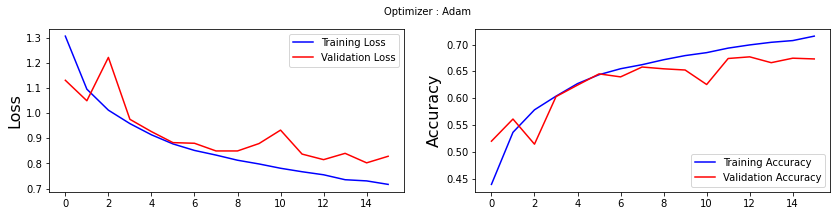

In [ ]:
import seaborn as sns
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(res.history['loss'], color='b', label='Training Loss')
plt.plot(res.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(res.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(res.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
score = model.evaluate(test_pix, test_ind, verbose=0)
score

[0.8287593126296997, 0.6731680631637573]

In [ ]:
from keras.models import model_from_json
import numpy as np

class FacialExpressionModel(object):
    EMOTIONS_LIST = ["Angry", "Disgust/fear/surprise","Sad","Happy", "Neutral"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        print("Model loaded from disk")
        self.loaded_model.summary()

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)

        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]


if __name__ == '__main__':
    pass

In [ ]:
import cv2
import numpy as np

rgb = cv2.VideoCapture(0)
facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
font = cv2.FONT_HERSHEY_SIMPLEX

def __get_data__():
    _, fr = rgb.read()
    gray = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
    faces = facec.detectMultiScale(gray, 1.3, 5)
    return faces, fr, gray

def start_app(cnn):
    skip_frame = 10
    data = []
    flag = False
    ix = 0
    while True:
        ix += 1
        
        faces, fr, gray_fr = __get_data__()
        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]
            
            roi = cv2.resize(fc, (48, 48))
            pred = cnn.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        if cv2.waitKey(1) == 27:
            break
        cv2.imshow('Filter', fr)
    cv2.destroyAllWindows()


if __name__ == '__main__':
    model = FacialExpressionModel("model1.json", "chkPt1.h5")
    start_app(model)

Model loaded from disk
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 44, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 41, 64)        65600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 41, 41, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 41, 41, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (Non

2022-06-26 16:05:49.018176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
